In [106]:
import numpy as np
import matplotlib.pyplot as plt

In [107]:
timecalc = 9
tolerance = 1e-7

# load the data
p_ind_read, frame_read, x_read, y_read = np.genfromtxt(
    "./20170202c059_RPE1_CAG_H2B_Halotag_TMR80pM_nonlam_non_starve_ctrl_info.txt",
    unpack=True,
)

# data
data = np.array([p_ind_read, frame_read, x_read, y_read])
data = data.T

In [108]:
# print all shapes
print("data.shape", data.shape)
print("data[0] : ", data[0])

data.shape (11579, 4)
data[0] :  [  1.     0.   148.37 108.4 ]


In [109]:
class Nucleosome:
    def __init__(self, p_ind, data):
        self.p_ind = p_ind
        self.traj = self.get_traj(data)
        self.in_time = self.traj[0, 0]
        self.out_time = self.traj[-1, 0]
        
    
    def get_traj(self, data):
        traj = data[data[:, 0] == self.p_ind]
        traj = traj[:, 1:4]                         # have only [frame, x, y]
        return traj
    

1342
(1342,)


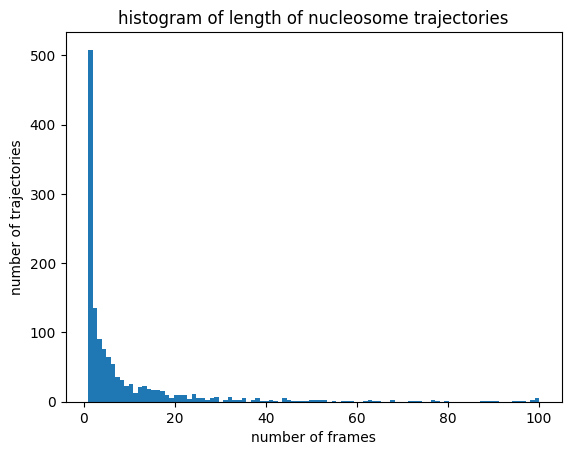

In [110]:
# initialize nucleosomes
nucleosomes = []
for p_ind in np.unique(data[:, 0]):
    nucleosomes.append(Nucleosome(p_ind, data))

hist = []
print(len(nucleosomes))
for nucleosome in nucleosomes:
    if len(nucleosome.traj) > 0:
        hist.append(len(nucleosome.traj))
    # print(len(nucleosome.traj))

hist = np.array(hist)
print(hist.shape)
plt.hist(hist, bins=max(hist))
plt.title("histogram of length of nucleosome trajectories")
plt.xlabel("number of frames")
plt.ylabel("number of trajectories")
plt.show()

In [111]:
# calculate msd for each trajectory
msd = []
for n in nucleosomes:
    curmsd = np.zeros(n.traj.shape[0])
    for i in range(1, n.traj.shape[0]):
        # vectorized
        curmsd[i] = np.sum((n.traj[i:, 1:3] - n.traj[0:-i, 1:3])**2) / (n.traj.shape[0] - i)
    msd.append(curmsd)
# msd = np.array(msd)

/tmp/ipykernel_15752/1147378223.py:5: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(np.arange(0, 5, 0.05))
/tmp/ipykernel_15752/1147378223.py:8: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(msd[i])


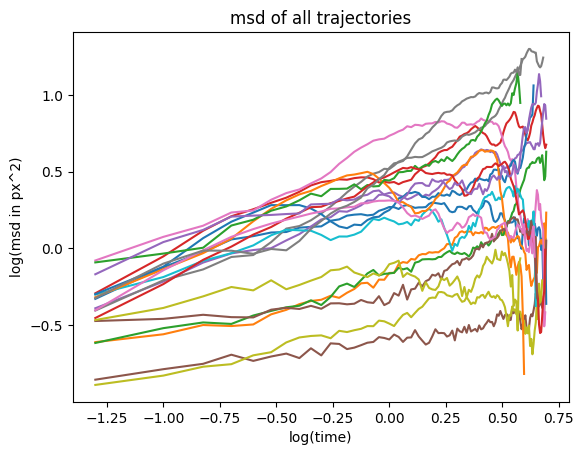

In [112]:
# plot all msd
# y is log of msd
# x is log of time
# np arange 100 frames from 0 s to 5 s
x = np.log10(np.arange(0, 5, 0.05))
for i in range(len(msd)):
    if len(msd[i]) > 75:
        y = np.log10(msd[i])
        # plt.plot(msd[i])
        plt.plot(x[:len(y)], y)
plt.title("msd of all trajectories")
plt.xlabel("log(time)")
plt.ylabel("log(msd in px^2)")
plt.show()